In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Zrimec2020r

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp06-zrimec2020r'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-values.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Regression

In [6]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 32,
		'valid' : 32,
		'test'  : 32
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	}
}

# Ensure correct
config['output']['length'] = len(tpm_order[config['output']['group0']])

In [7]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 745310324


## 2.1 Data

In [8]:
# Get the correct output group

gene_targets = {
	key : value[config['output']['group1']]
	for key, value in tpm_value.items()
}

In [9]:
# Transform the data dictionaries into lists

names = sorted(list(gene_sequences.keys()))

sequences = numpy.array([gene_sequences[key] for key in names])
features  = numpy.array([gene_frequency[key] for key in names])
targets   = numpy.array([gene_targets[key]   for key in names])

In [10]:
# Create the dataset and generte split indices using sklearn

dataset = GeneDataset(
	names       = names,
	sequences   = sequences,
	features    = features,
	targets     = targets,
	expand_dims = None
)

train_idx, valid_idx, test_idx = cnn_dataset.generate_split_indices(
	targets     = targets,
	valid_split = config['split_size']['valid'],
	test_split  = config['split_size']['test'],
	random_seed = config['random_seed']
)

In [11]:
# Create train dataloader and display batch dimensions

train_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = train_idx,
	batch_size = config['batch_size']['train']
)

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     32
Dataloader  batch count :    633
Dataloader sample count : 20,256

     Key shape : (32,)
Sequence shape : torch.Size([32, 4, 2150])
 Feature shape : torch.Size([32, 64])
  Target shape : torch.Size([32, 8])


In [12]:
# Create valid dataloader and display batch dimensions

valid_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = valid_idx,
	batch_size = config['batch_size']['valid']
)

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     32
Dataloader  batch count :    158
Dataloader sample count :  5,056

     Key shape : (32,)
Sequence shape : torch.Size([32, 4, 2150])
 Feature shape : torch.Size([32, 64])
  Target shape : torch.Size([32, 8])


In [13]:
# Create test dataloader and display batch dimensions

test_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = test_idx,
	batch_size = config['batch_size']['test']
)

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     32
Dataloader  batch count :    198
Dataloader sample count :  6,336

     Key shape : (32,)
Sequence shape : torch.Size([32, 4, 2150])
 Feature shape : torch.Size([32, 64])
  Target shape : torch.Size([32, 8])


## 2.2 Model

### 2.2.1 Structure

In [14]:
# Create and display the model structure

model = Zrimec2020r(params = {
	'other' : {
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.1
	},
	'conv1' : {
		'filters' : 32,
		'kernel'  : 41,
		'padding' : 'none'
	},
	'conv2' : {
		'filters' : 128,
		'kernel'  : 41,
		'padding' : 'same'
	},
	'conv3' : {
		'filters' : 128,
		'kernel'  : 11,
		'padding' : 'same'
	},
	'maxpool1' : {
		'kernel'  : 9,
		'padding' : 'same'
	},
	'maxpool2' : {
		'kernel'  : 3,
		'padding' : 'same'
	},
	'maxpool3' : {
		'kernel'  : 9,
		'padding' : 'same'
	},
	'fc1' : {
		'features' : 256
	},
	'fc2' : {
		'features' : 512
	},
	'fc3' : {
		'features' : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [32, 4, 2150]             [32, 8]                   --
├─Zrimec2020: 1-1                        [32, 4, 2150]             [32, 512]                 --
│    └─Conv1d: 2-1                       [32, 4, 2150]             [32, 32, 2110]            5,280
│    └─ReLU: 2-2                         [32, 32, 2110]            [32, 32, 2110]            --
│    └─BatchNorm1d: 2-3                  [32, 32, 2110]            [32, 32, 2110]            64
│    └─Dropout: 2-4                      [32, 32, 2110]            [32, 32, 2110]            --
│    └─MaxPool1d: 2-5                    [32, 32, 2110]            [32, 32, 422]             --
│    └─Conv1d: 2-6                       [32, 32, 422]             [32, 128, 422]            168,064
│    └─ReLU: 2-7                         [32, 128, 422]            [32, 128, 422]            --
│    └─BatchNorm1d: 2-8    

In [15]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

### 2.2.2 Parameters

In [16]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'mse',
	reduction = 'mean',
	weights   = None
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 0.001,
	betas        = (0.900, 0.999),
	weight_decay = 0.05
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 5,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 10,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'huber' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'huber'),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2')
	}
}

## 2.3 Training

In [17]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = params
)

### 2.3.1 Visualization

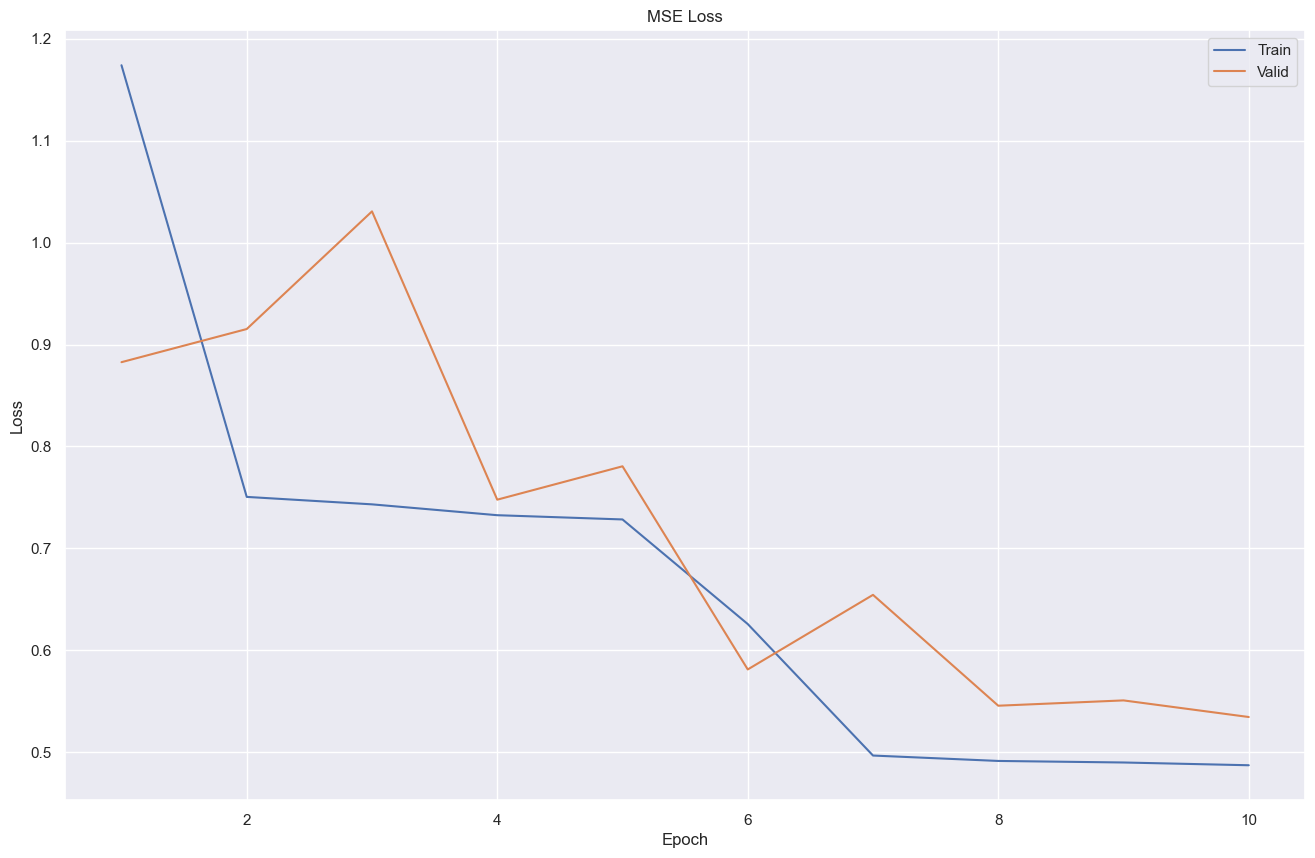

In [18]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

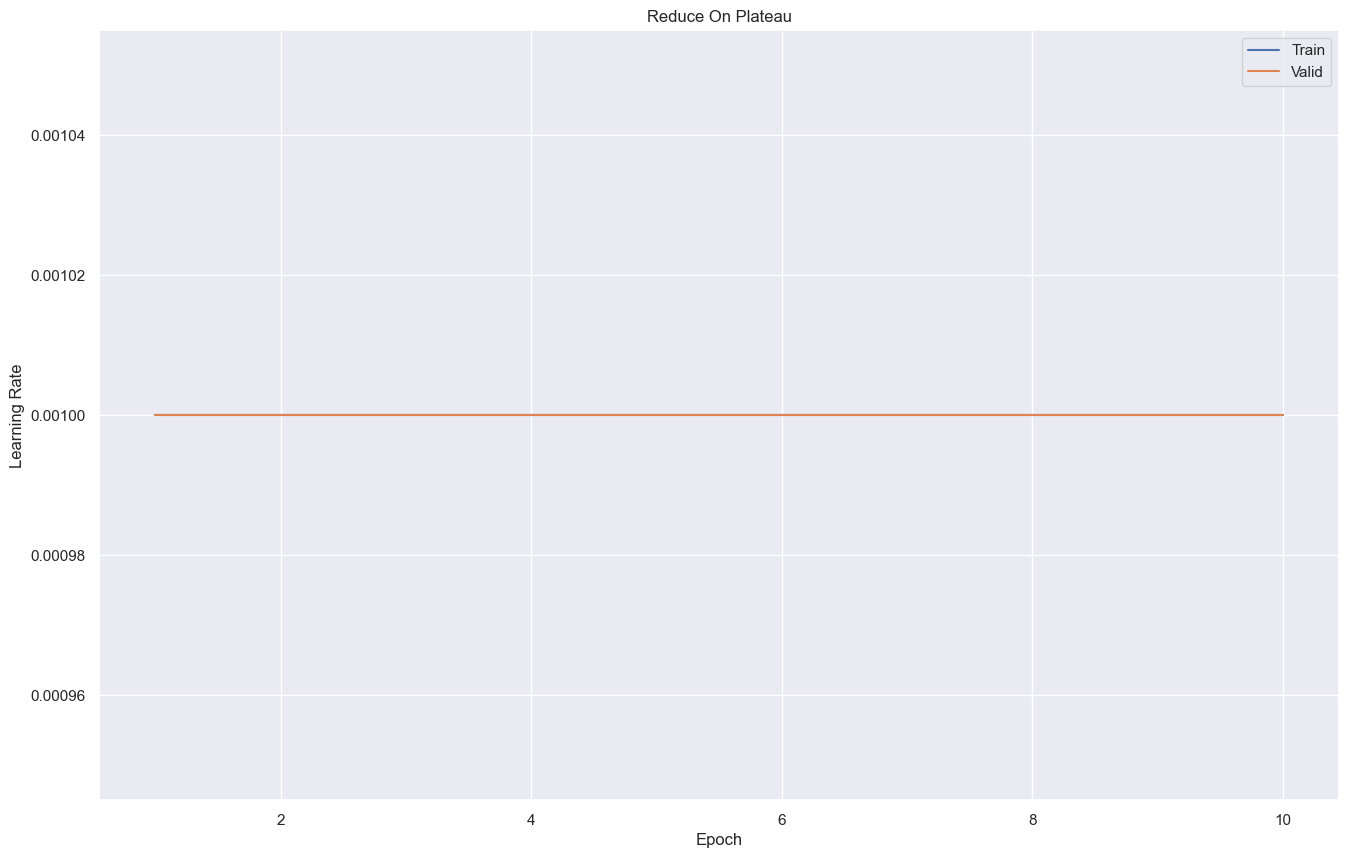

In [19]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

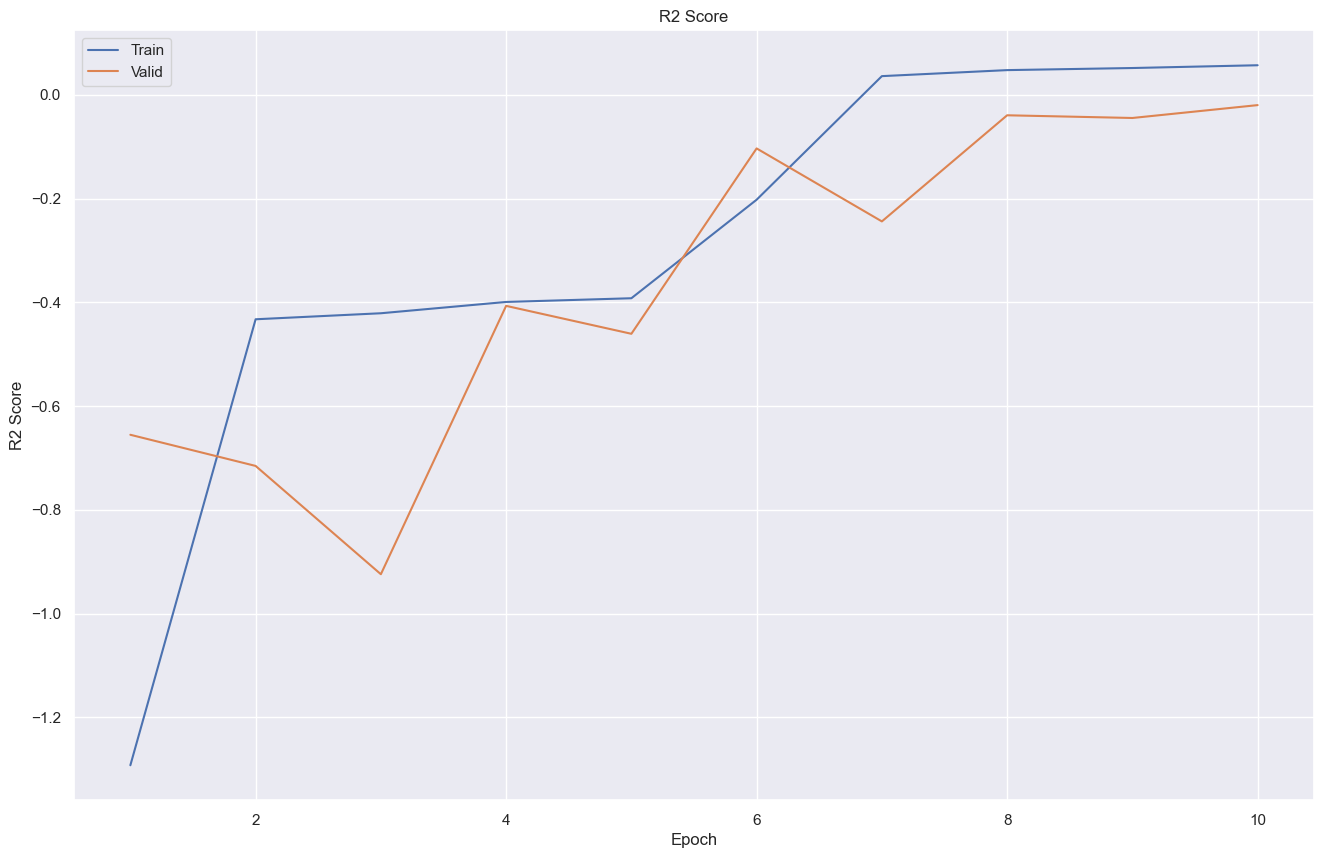

In [20]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

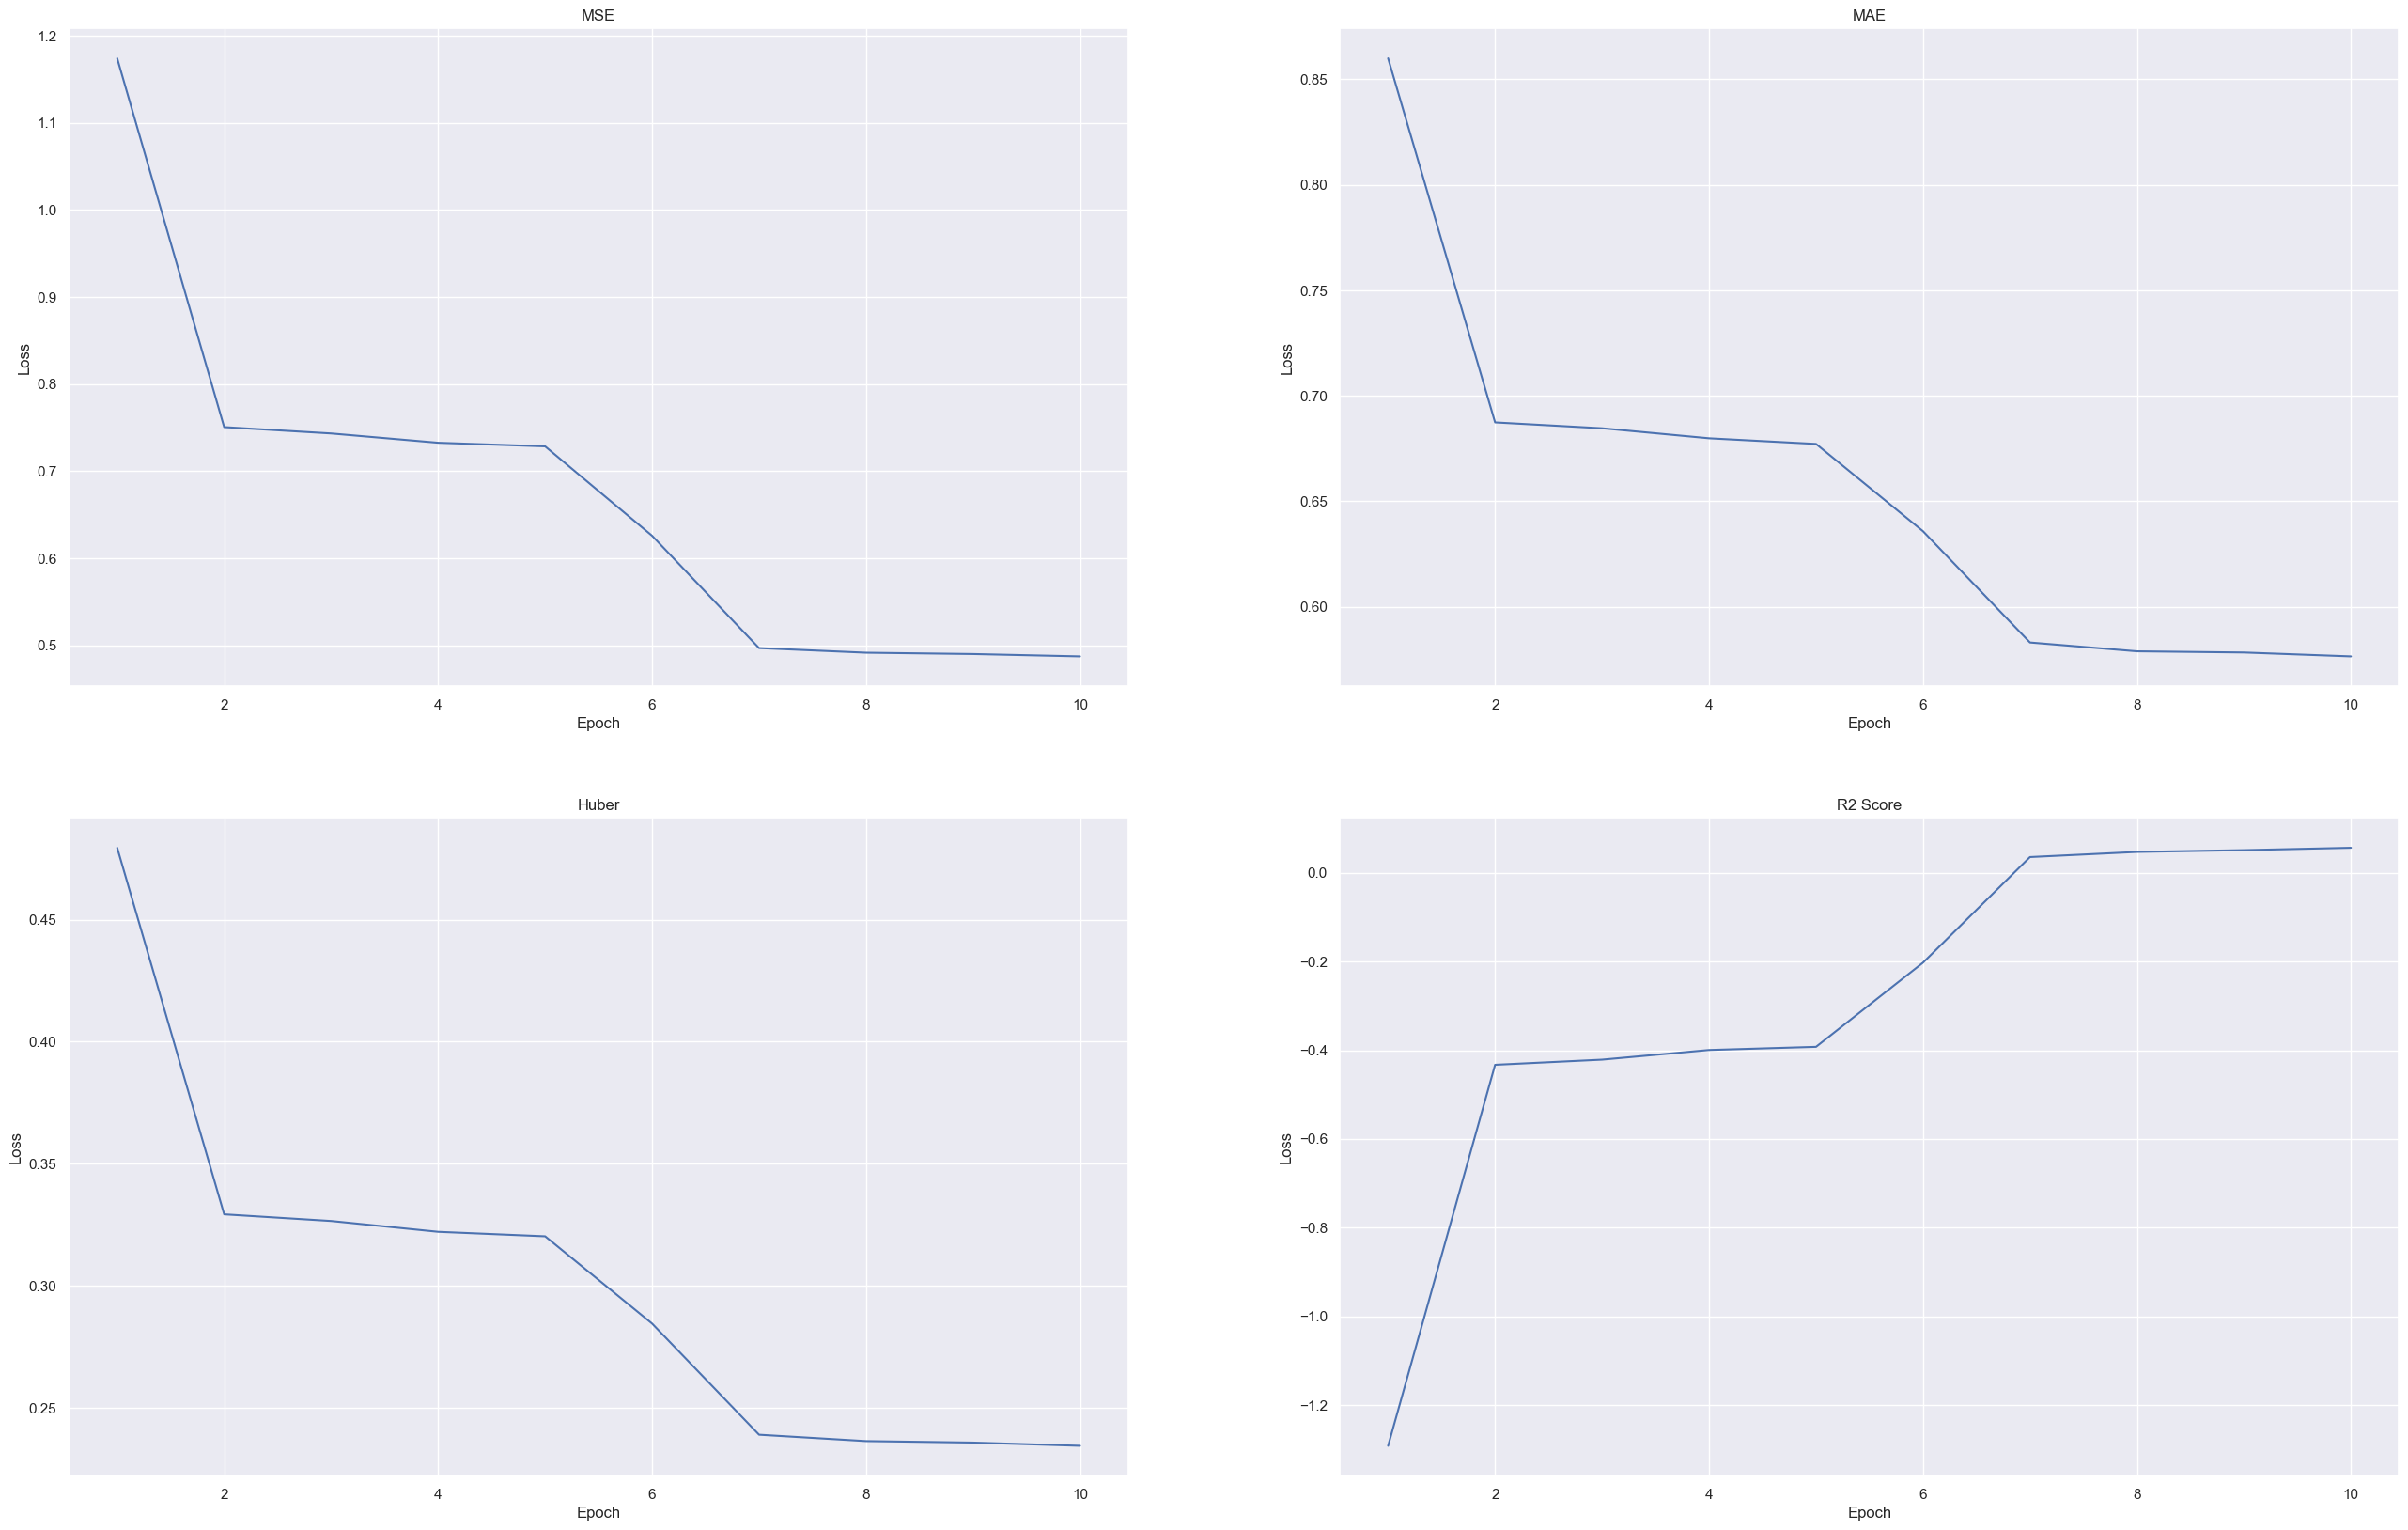

In [21]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

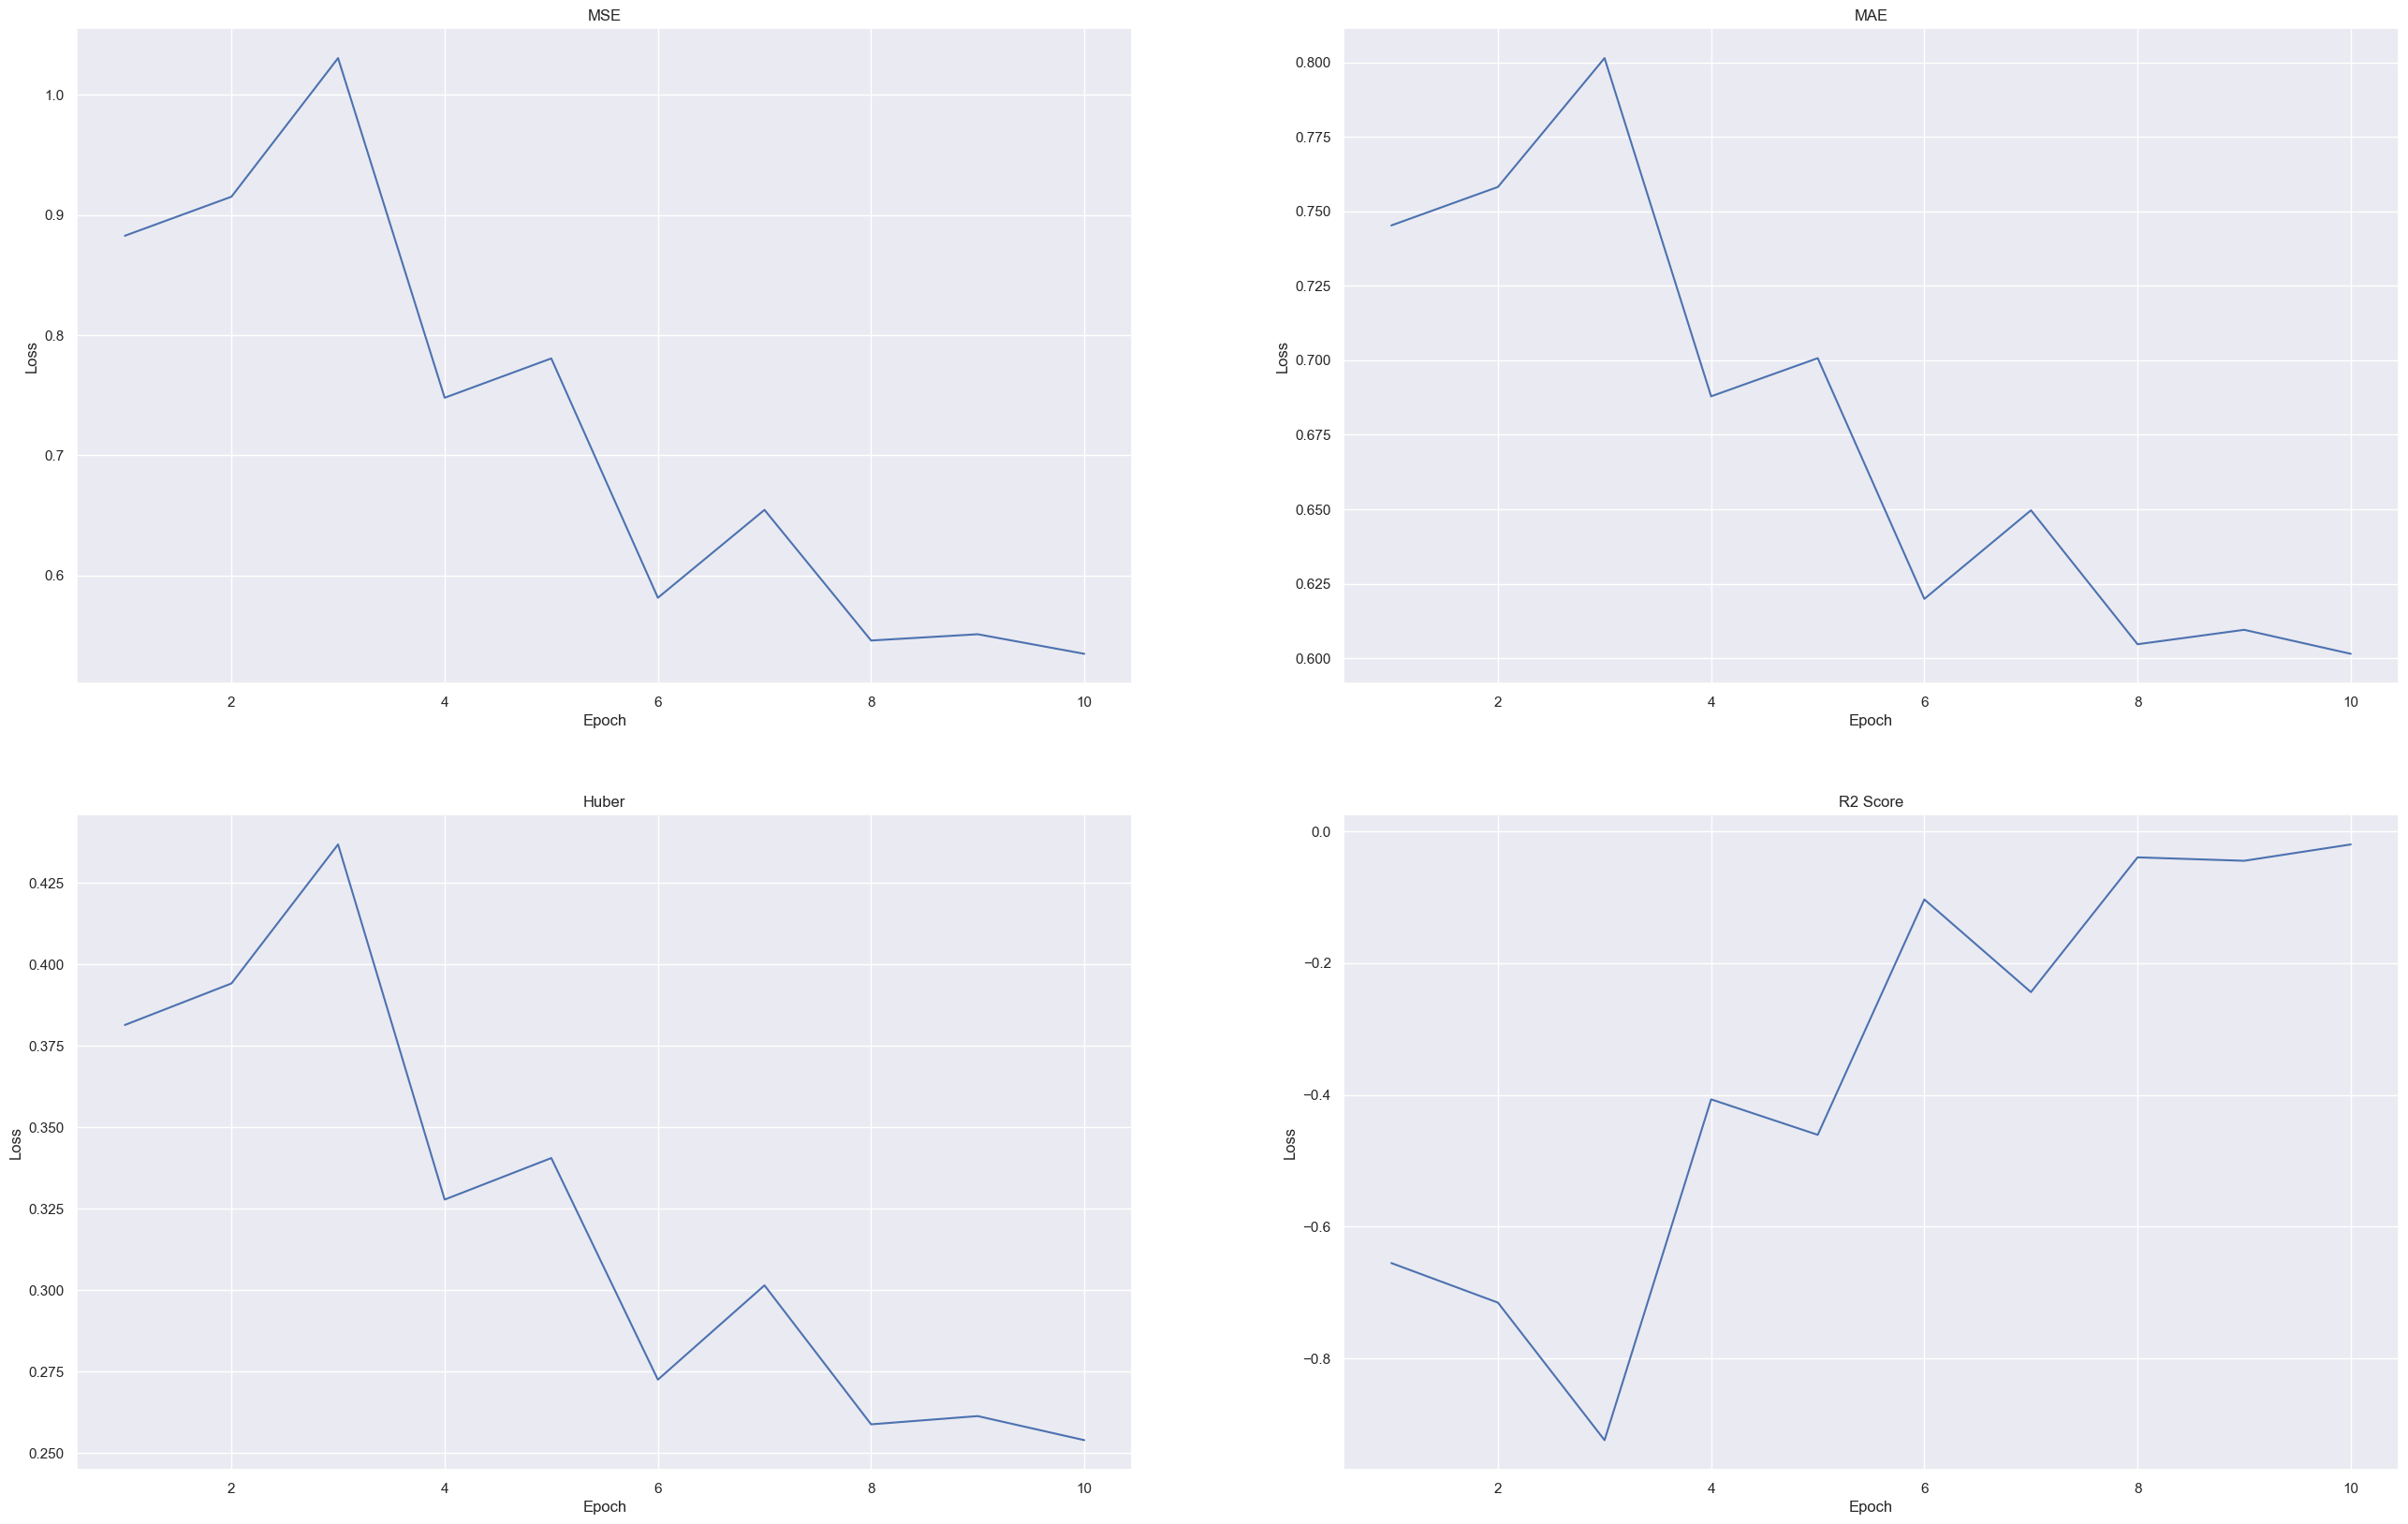

In [22]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [23]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
 Loss : 0.53460


<All keys matched successfully>

In [24]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [25]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score : -0.01989
MAE Loss :  0.60191
MSE Loss :  0.53939


In [26]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT5G13220.4
True : [ 1.36548    0.44687    0.99565    0.50835    0.61875    0.53110    0.65204    0.21520]
Pred : [ 1.51234    1.26570    1.27779    1.42913    1.32800    1.39700    1.04190    0.65381]
 MAE : [ 0.14685    0.81883    0.28214    0.92078    0.70924    0.86590    0.38986    0.43861]
 MSE : [ 0.02157    0.67048    0.07960    0.84783    0.50303    0.74978    0.15199    0.19238]
 R2  : [-0.05630    0.00924   -0.01584   -0.02769   -0.01074   -0.08741    0.05488    0.03871]

Gene : AT4G28040.1
True : [ 0.76332    0.29256    0.91368    1.36285    0.38544    0.98721    0.32022    0.00000]
Pred : [ 0.97877    0.79930    0.82317    0.91472    0.84051    0.89243    0.66471    0.40458]
 MAE : [ 0.21544    0.50674    0.09050    0.44813    0.45507    0.09478    0.34449    0.40458]
 MSE : [ 0.04642    0.25678    0.00819    0.20082    0.20709    0.00898    0.11867    0.16369]
 R2  : [-0.12404   -0.01079   -0.05631   -0.01442   -0.11317   -0.05661    0.09258   -0.09256]



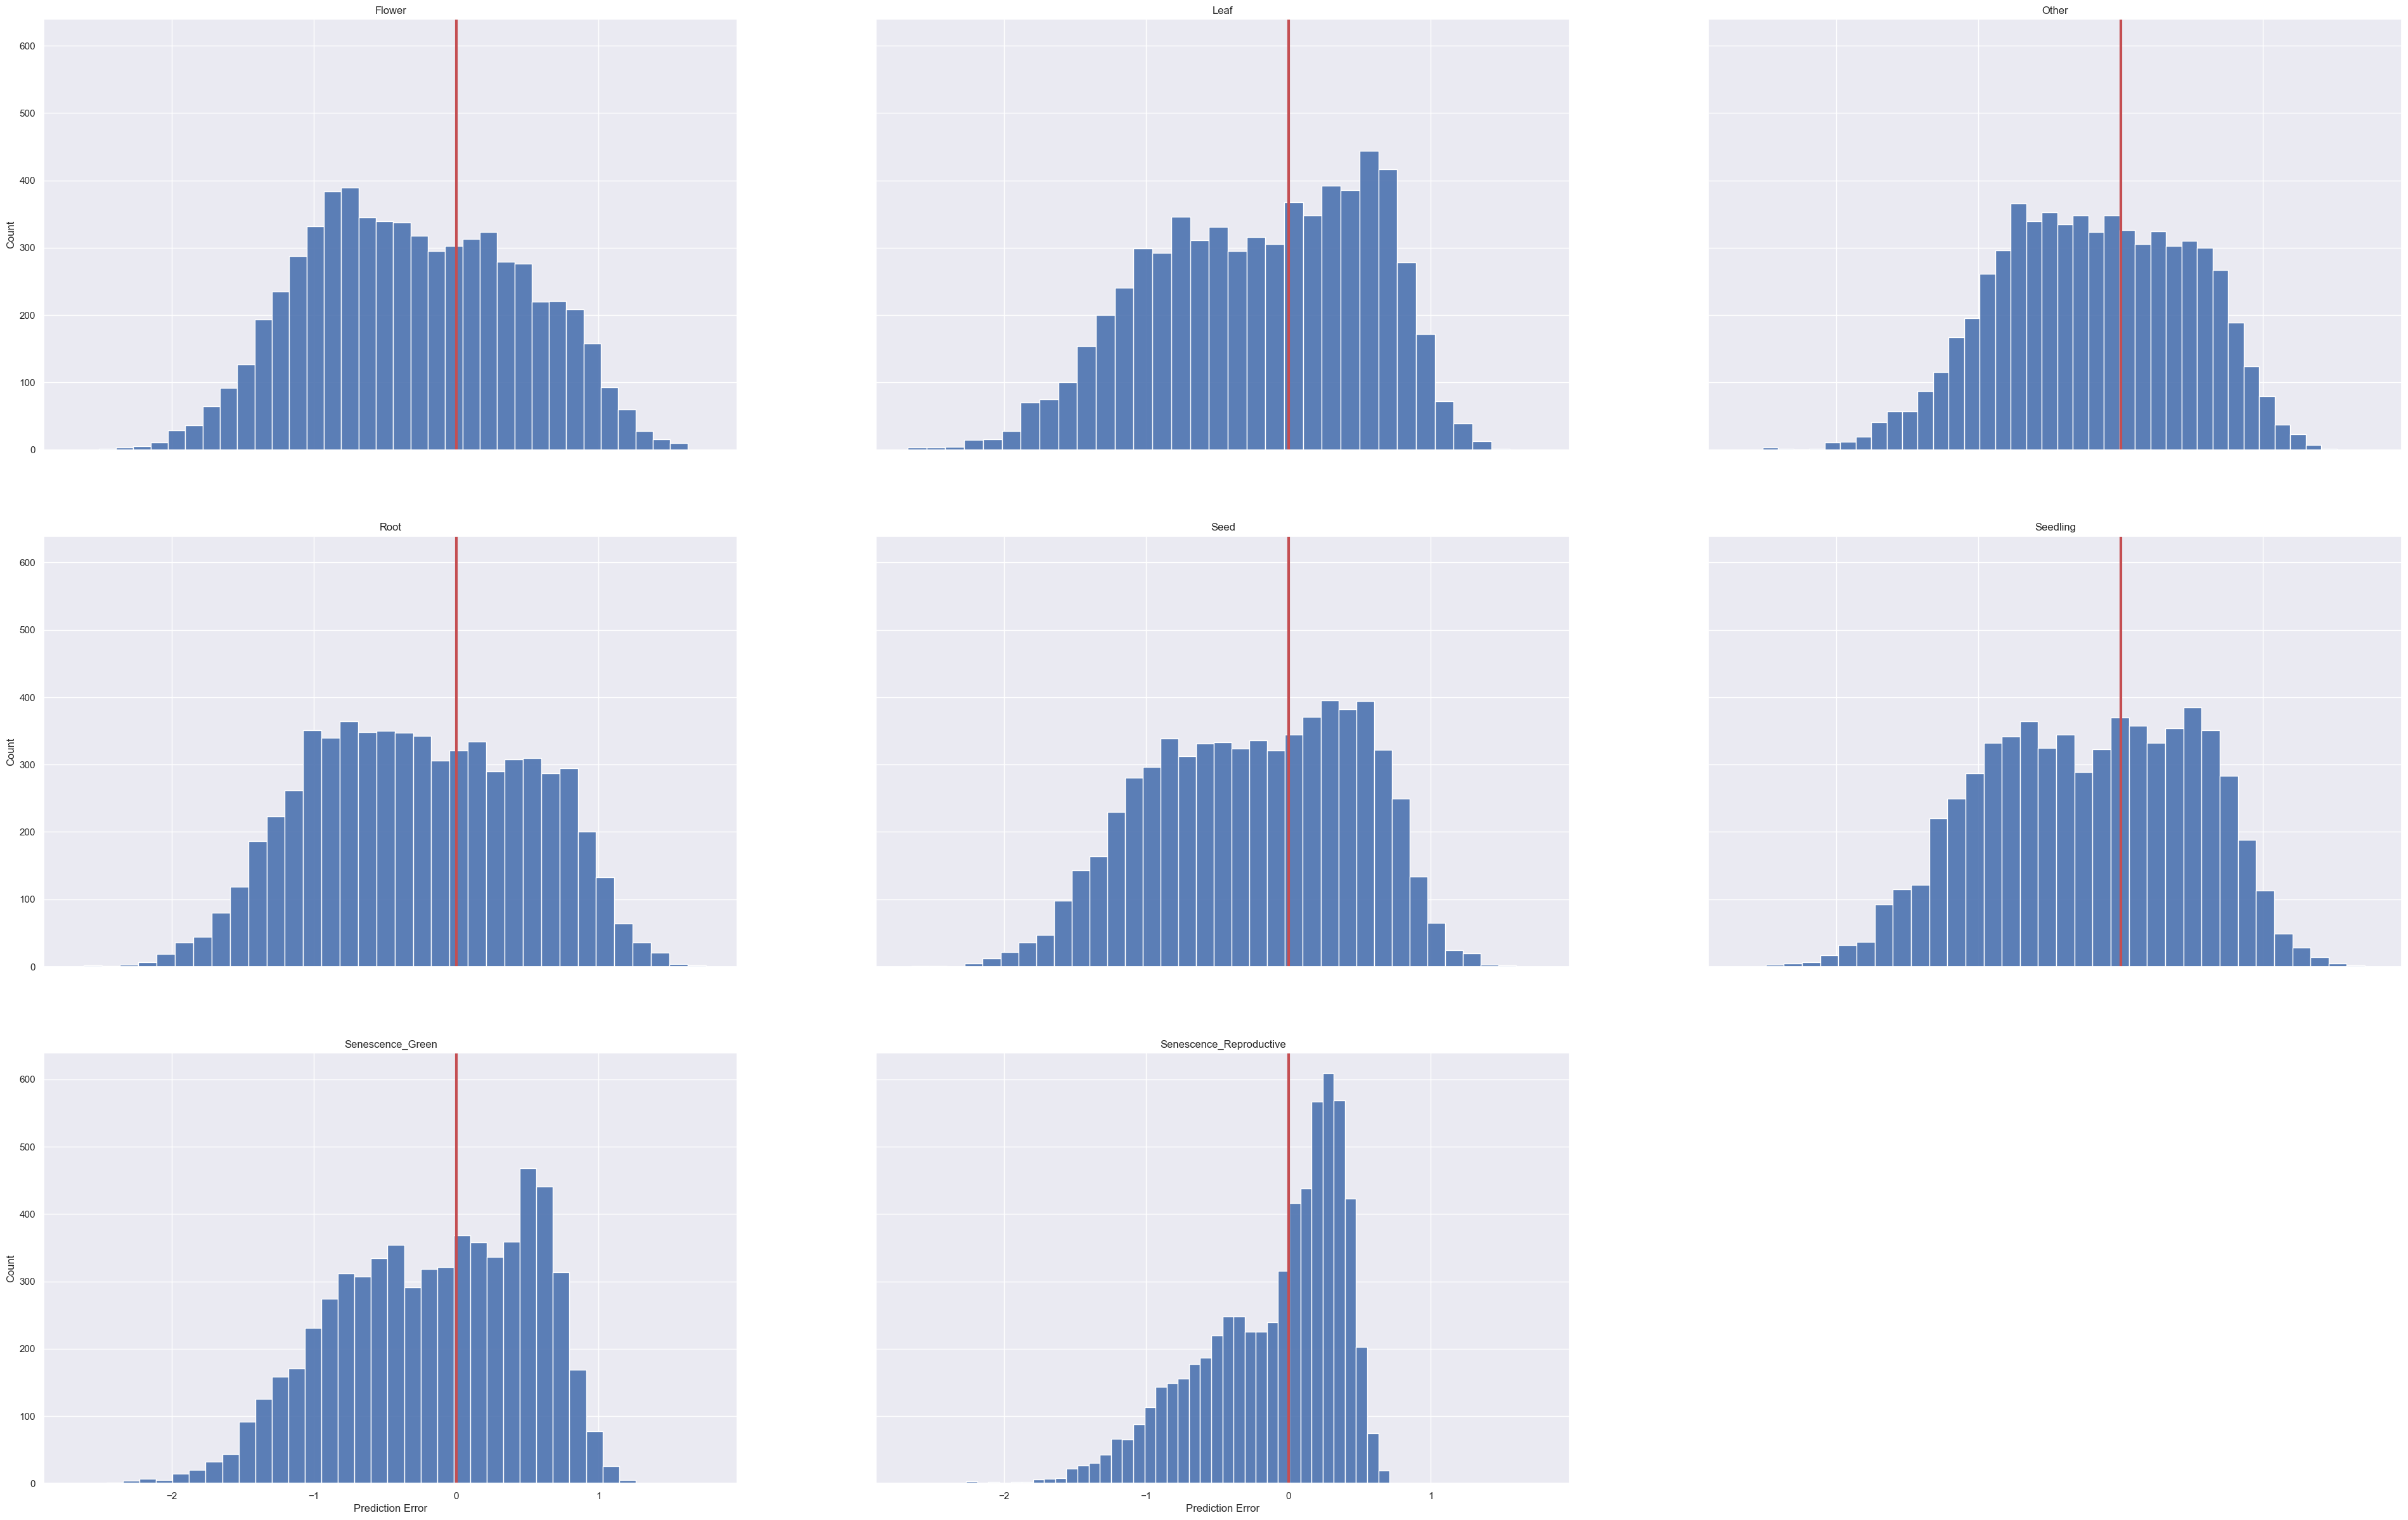

In [27]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

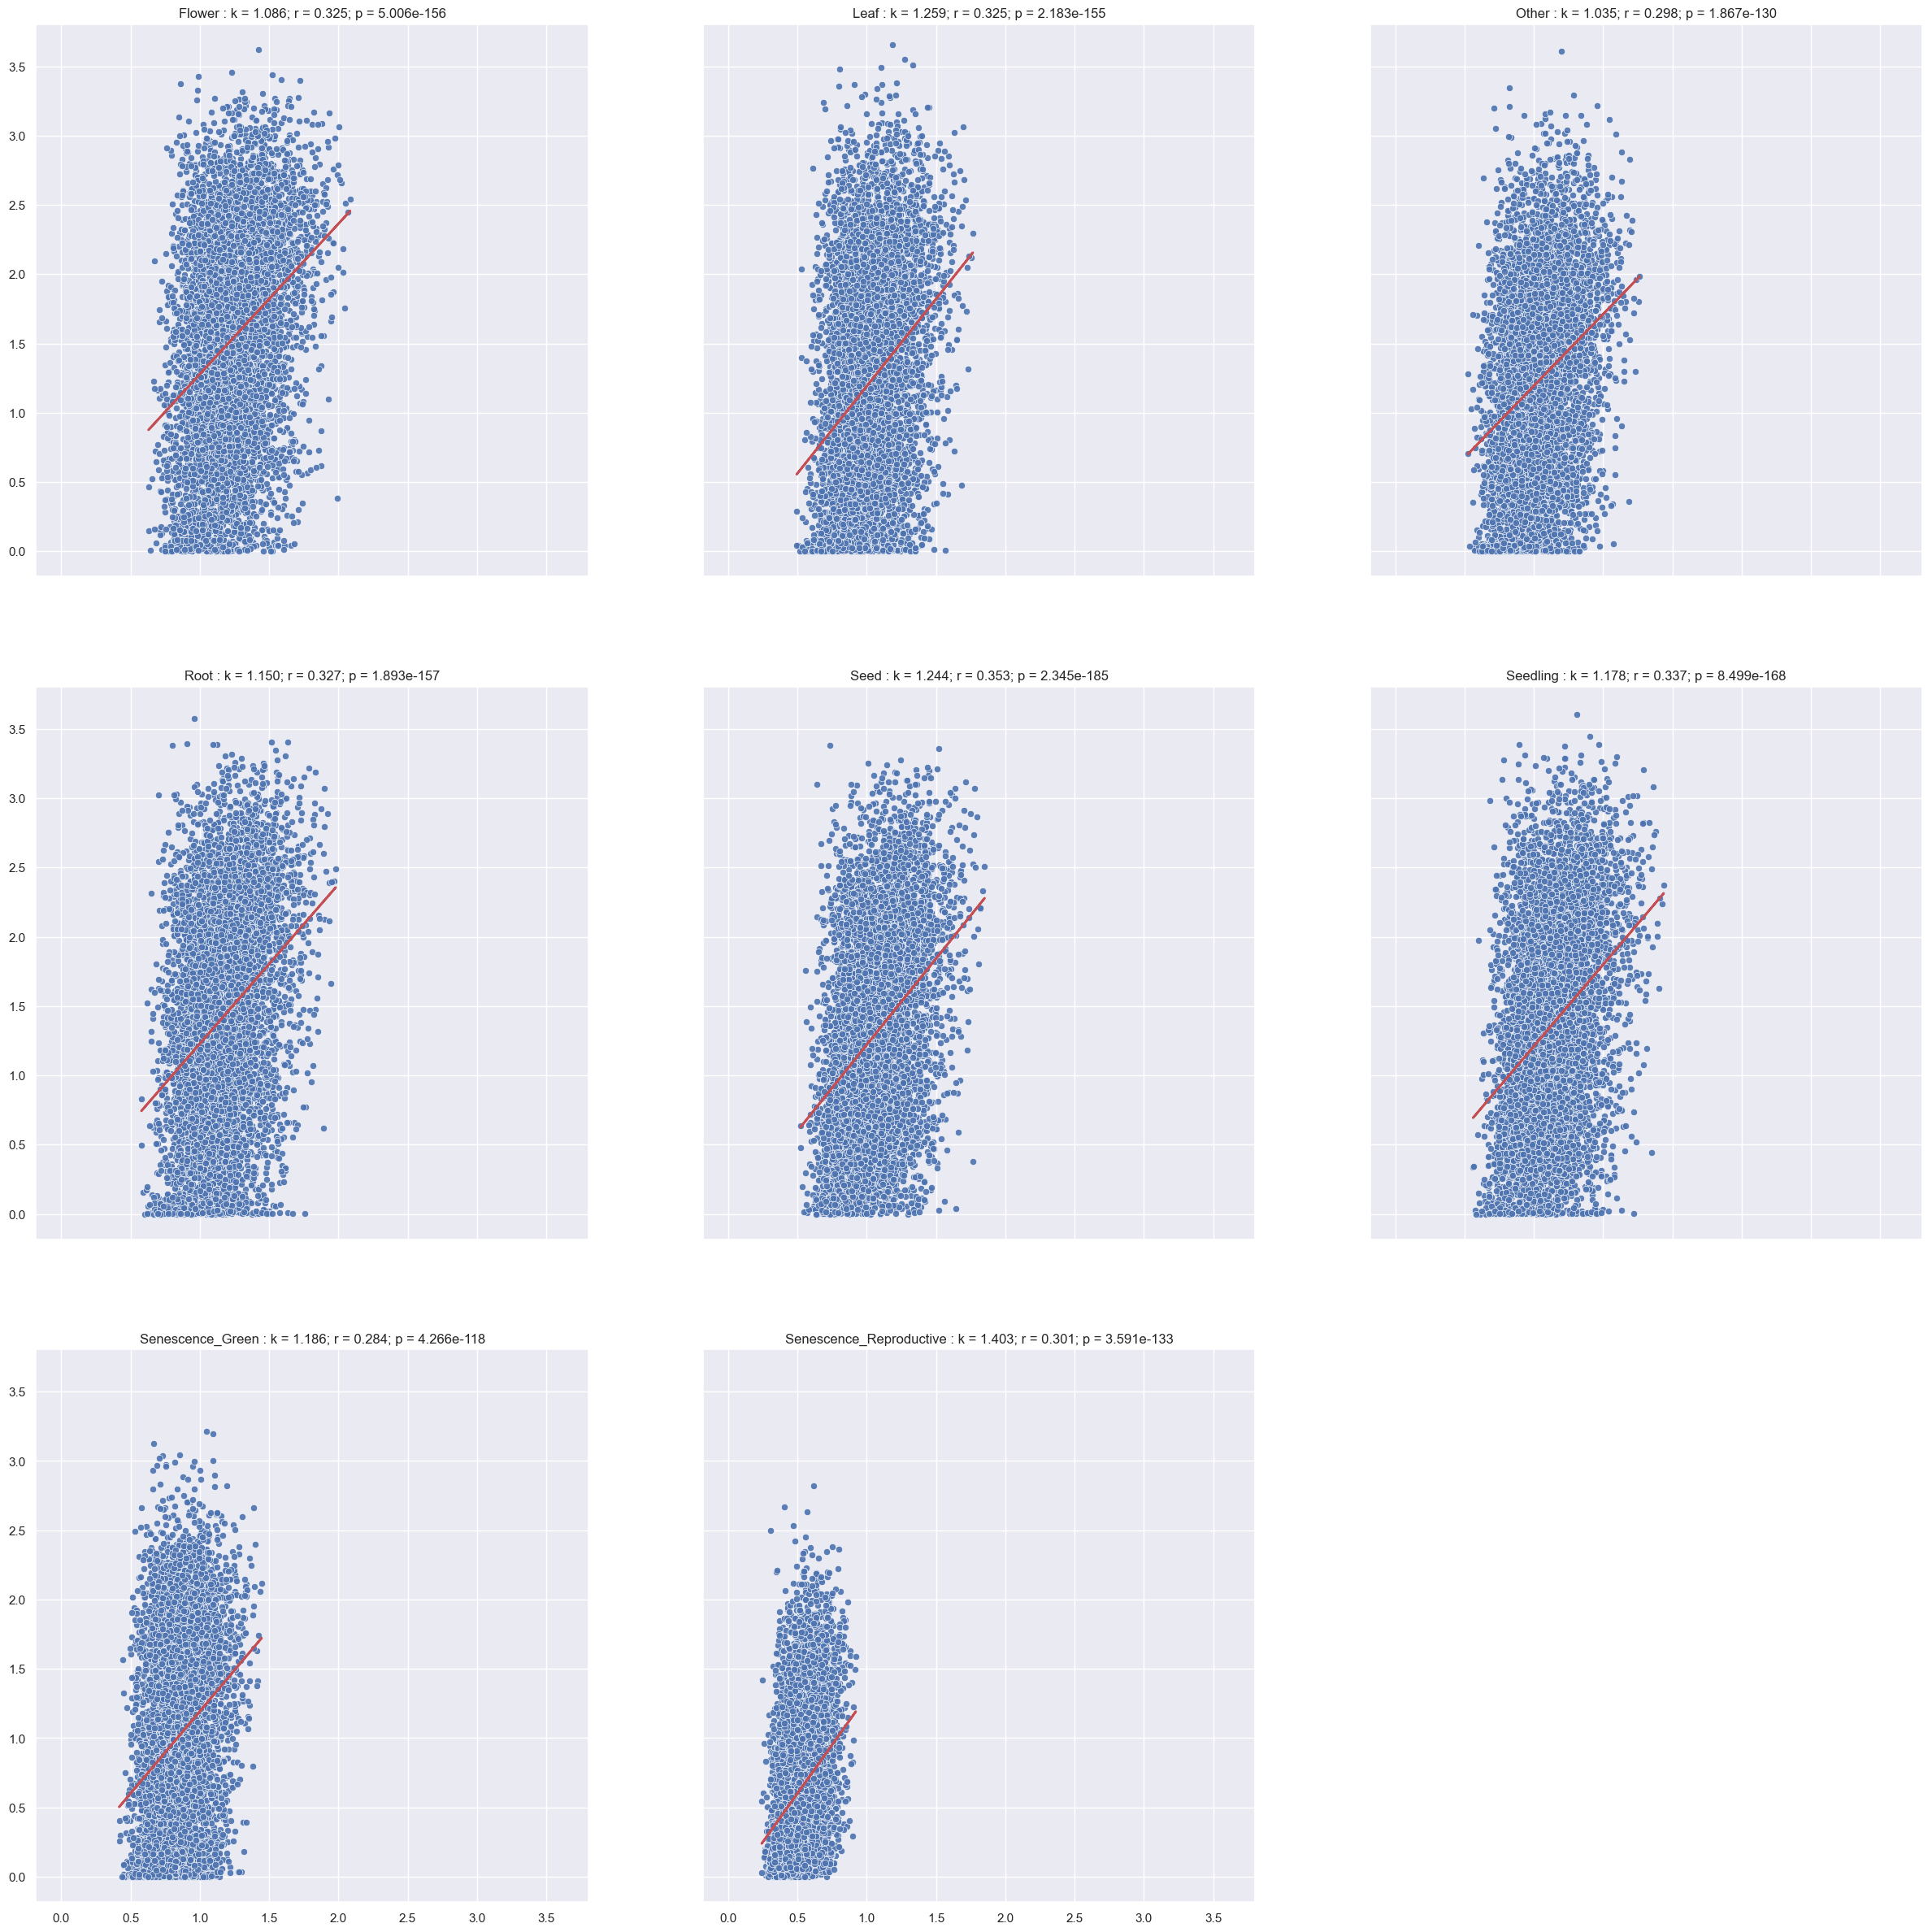

In [28]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

In [29]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  45.30 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
7  senescence_reproductive   6336   4077    64.347    0.397    0.315
6         senescence_green   6336   3857    60.874    0.573    0.387
2                    other   6336   3322    52.431    0.576    0.393
4                     seed   6336   2827    44.618    0.624    0.427
1                     leaf   6336   2365    37.326    0.654    0.441
5                 seedling   6336   2345    37.011    0.643    0.435
3                     root   6336   2284    36.048    0.673    0.439
0                   flower   6336   1884    29.735    0.676    0.441

### 2.4.2 Best Model

In [30]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 10
 Loss : 0.53460


<All keys matched successfully>

In [31]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [32]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score : -0.01573
MAE Loss :  0.60191
MSE Loss :  0.53937


In [33]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT5G40230.1
True : [ 0.67770    0.52749    0.82356    1.71094    1.23824    0.82380    1.03689    0.96563]
Pred : [ 1.07283    0.88152    0.90332    1.00541    0.92645    0.98138    0.73121    0.44852]
 MAE : [ 0.39513    0.35403    0.07976    0.70553    0.31179    0.15758    0.30569    0.51711]
 MSE : [ 0.15613    0.12534    0.00636    0.49778    0.09721    0.02483    0.09345    0.26741]
 R2  : [ 0.17259   -0.01391    0.11496    0.07341    0.18067    0.02134   -0.07461    0.12251]

Gene : AT1G76940.3
True : [ 1.66568    1.23636    1.32427    1.34330    1.35322    1.22609    0.90265    0.48484]
Pred : [ 1.09609    0.90186    0.92314    1.02783    0.94770    1.00338    0.74765    0.45939]
 MAE : [ 0.56959    0.33450    0.40113    0.31547    0.40552    0.22271    0.15500    0.02545]
 MSE : [ 0.32443    0.11189    0.16090    0.09952    0.16445    0.04960    0.02403    0.00065]
 R2  : [-0.14722    0.16706    0.13190    0.14166    0.15741    0.17558    0.19427   -0.00611]



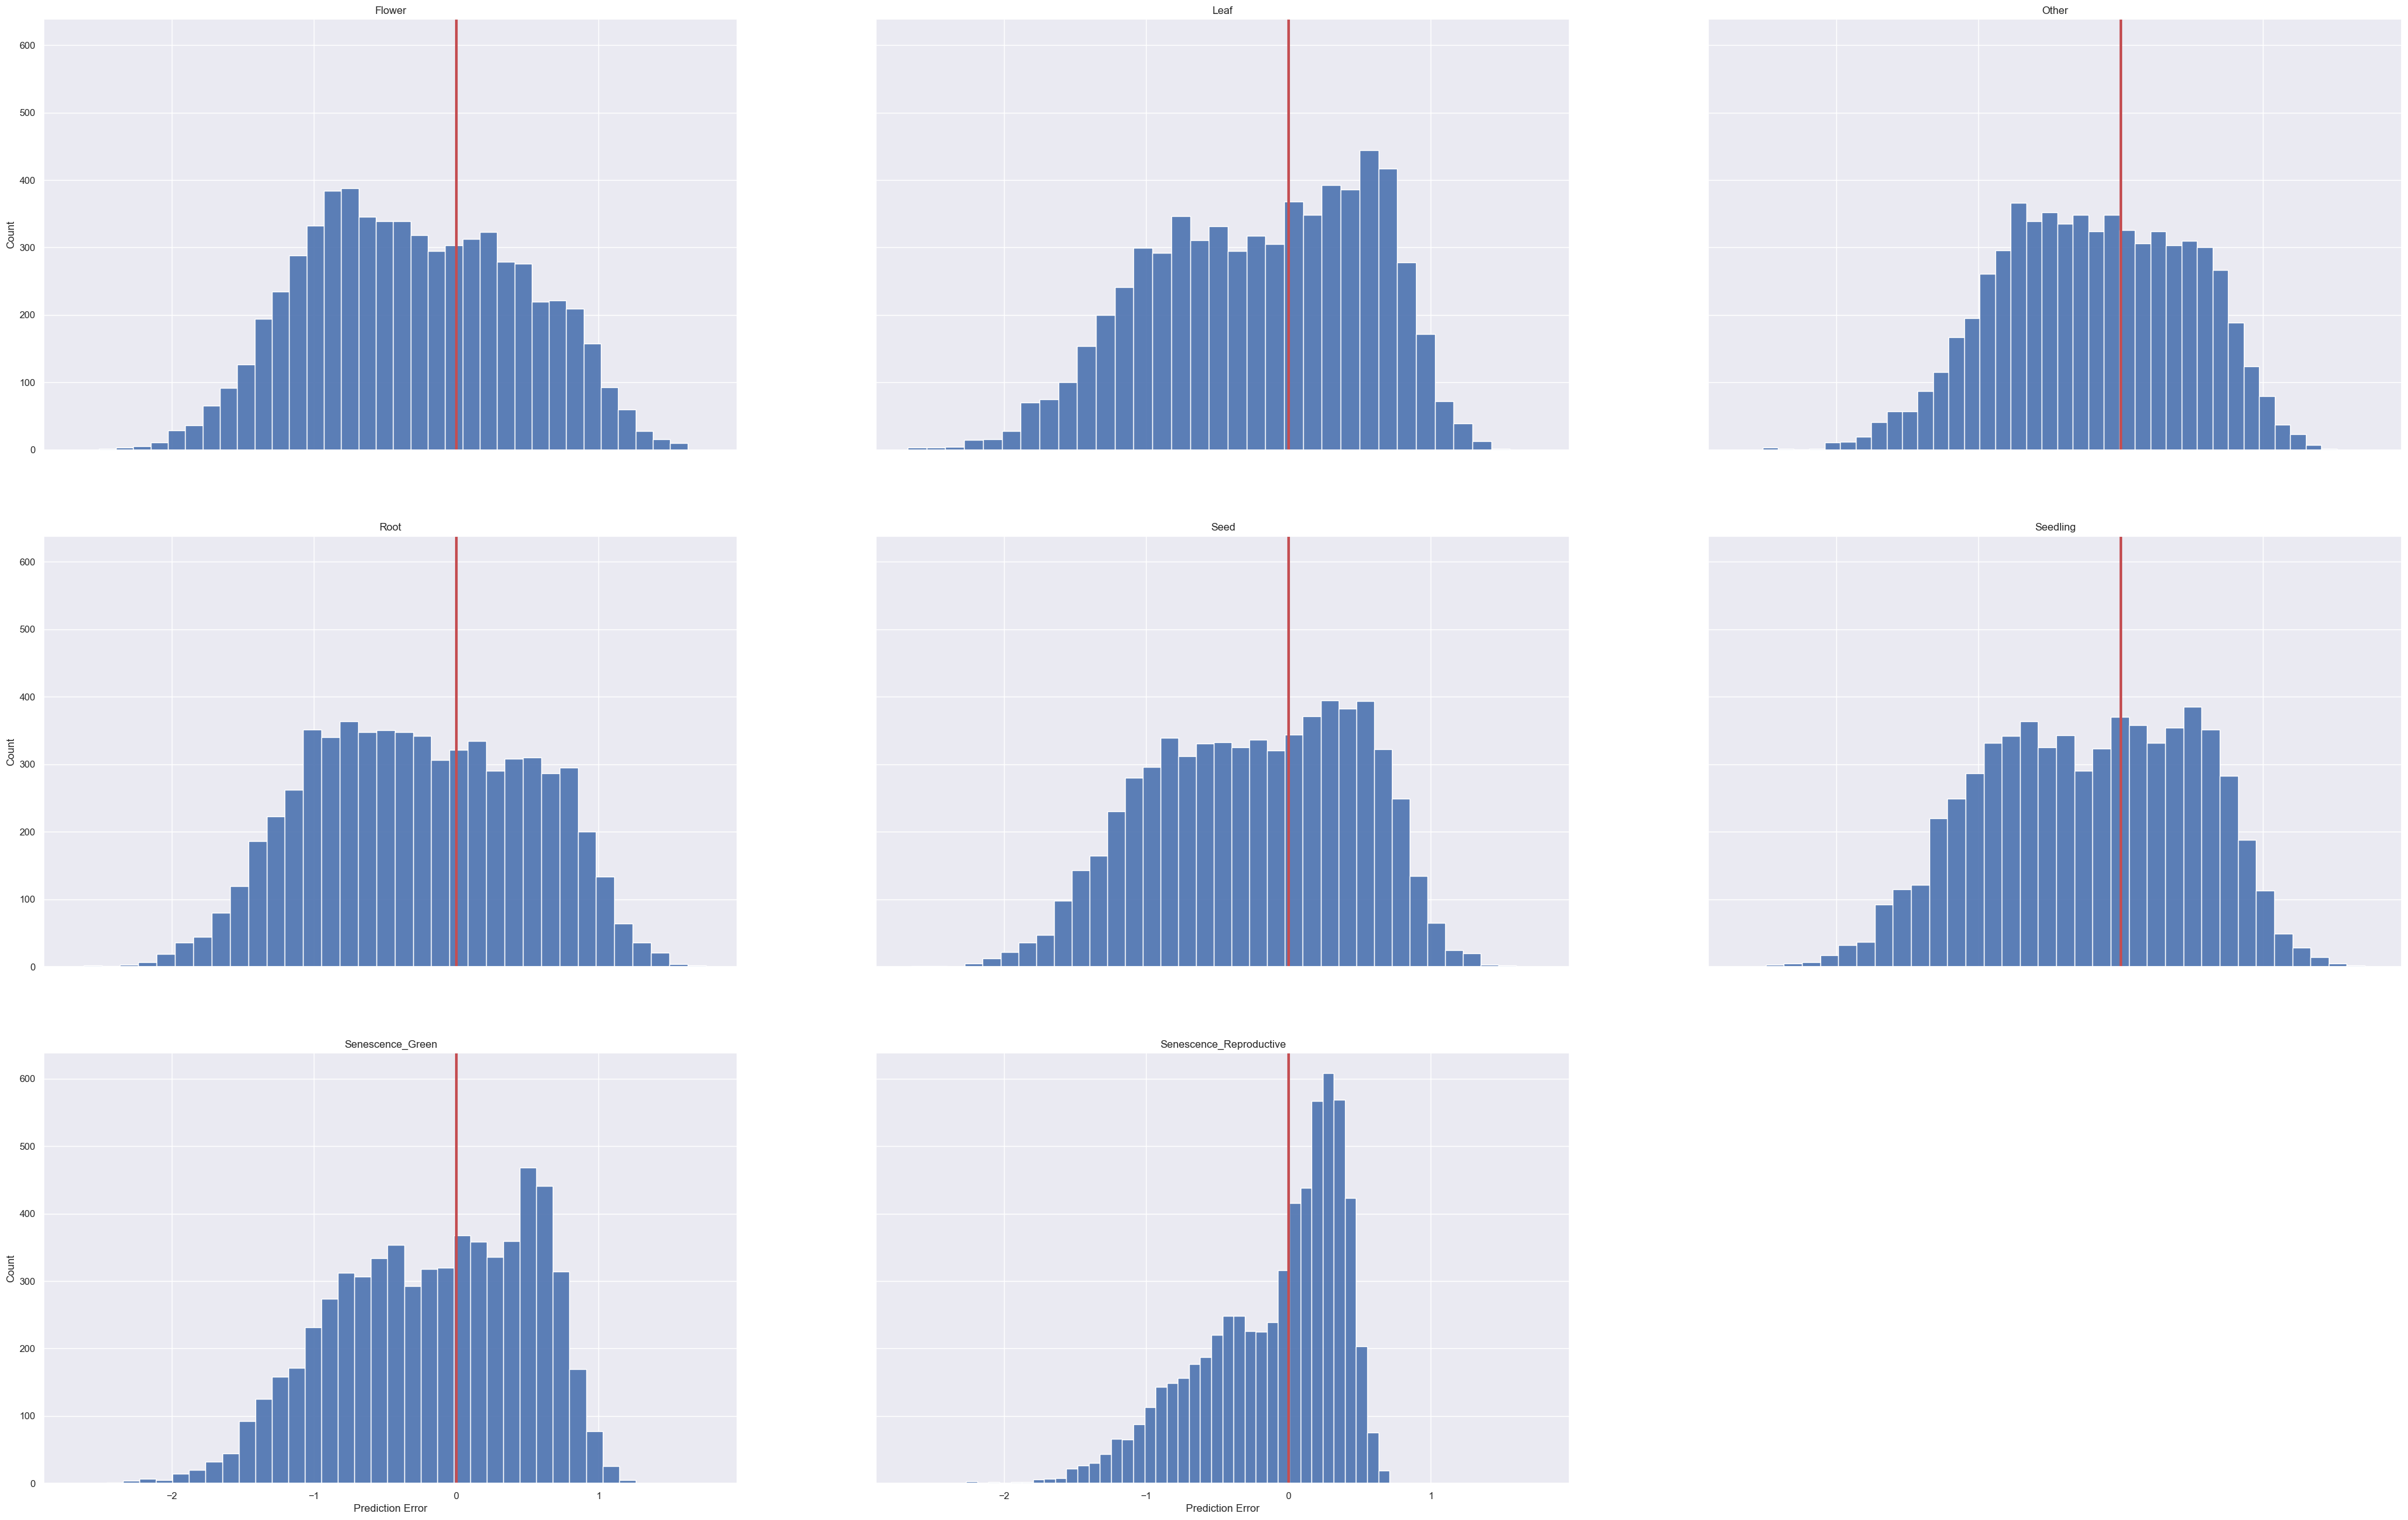

In [34]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

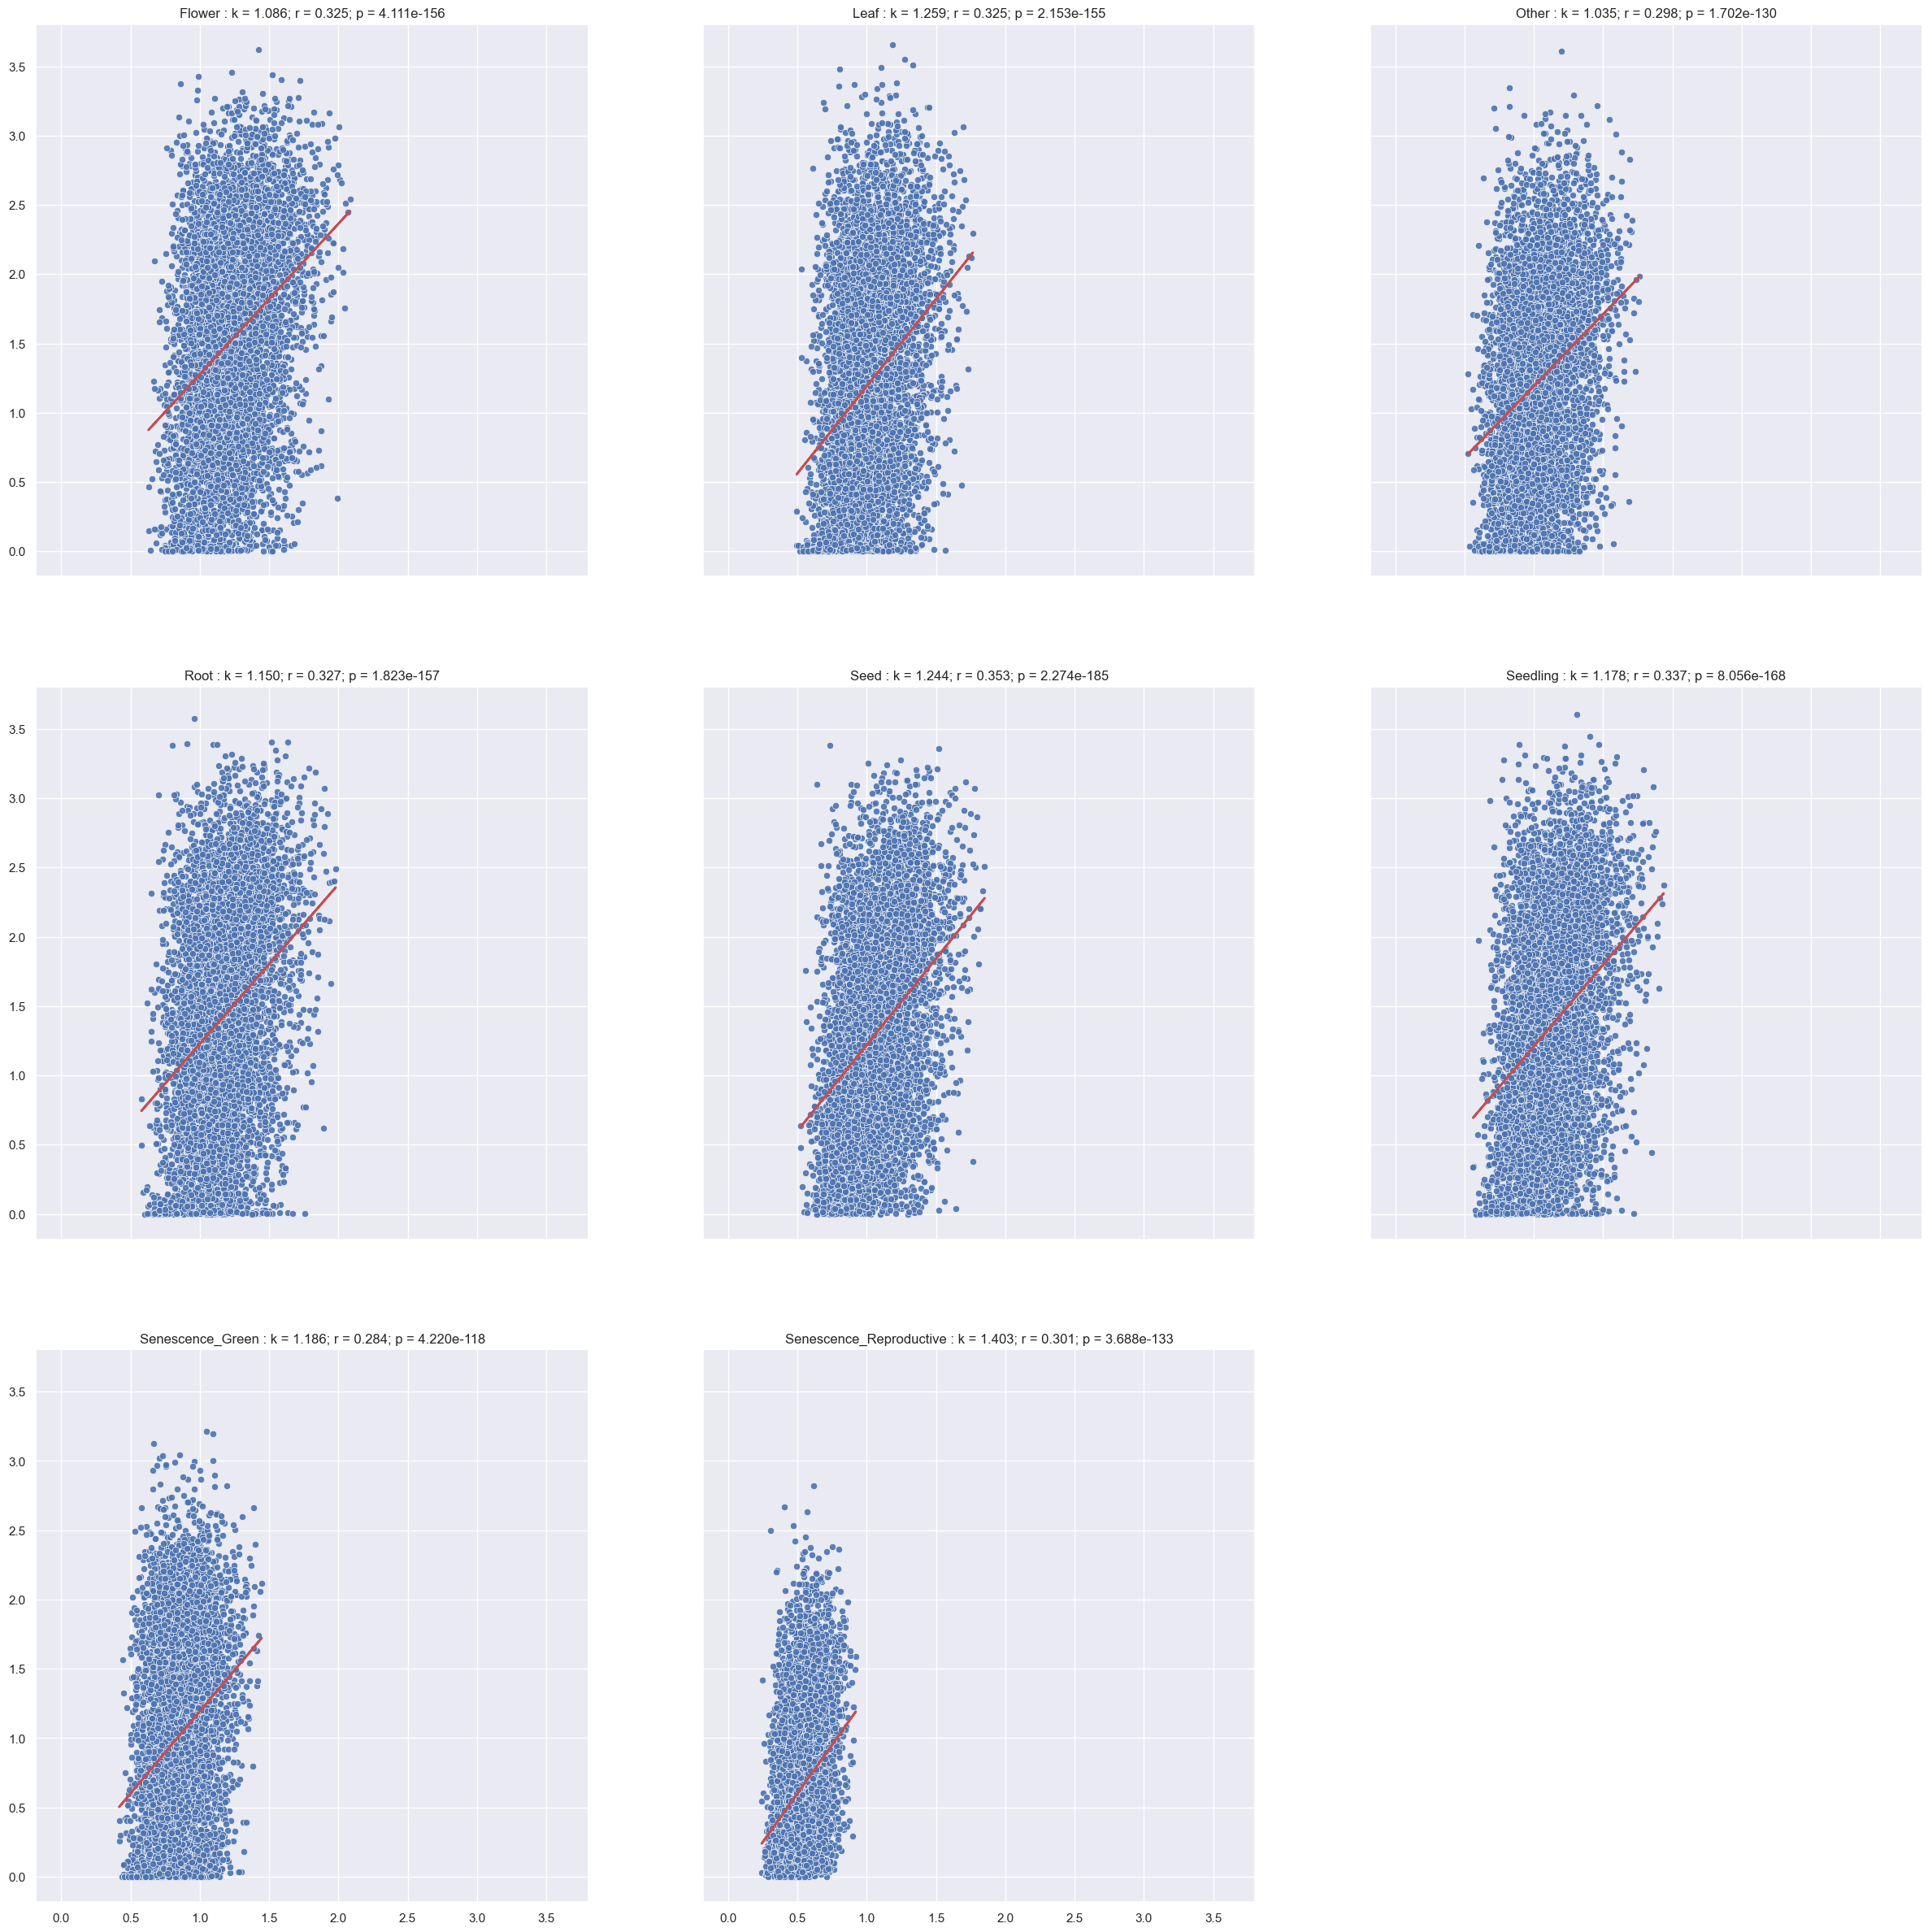

In [35]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

In [36]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  45.29 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
7  senescence_reproductive   6336   4077    64.347    0.397    0.315
6         senescence_green   6336   3857    60.874    0.573    0.387
2                    other   6336   3322    52.431    0.576    0.393
4                     seed   6336   2826    44.602    0.624    0.427
1                     leaf   6336   2365    37.326    0.654    0.441
5                 seedling   6336   2345    37.011    0.643    0.436
3                     root   6336   2283    36.032    0.673    0.439
0                   flower   6336   1884    29.735    0.675    0.441